In [18]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install pycaret
!pip install missingno

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 35.4 MB/s eta 0:00:00
   ━━━━━

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#Defining utility functions

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [ ]:
diabetes_df = pd.read_csv("/content/diabetes.csv")
diabetes_df.head().T.style.set_properties(**{'background-color': 'grey',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
Pregnancies,6.000000,1.000000,8.000000,1.000000,0.000000
Glucose,148.000000,85.000000,183.000000,89.000000,137.000000
BloodPressure,72.000000,66.000000,64.000000,66.000000,40.000000
SkinThickness,35.000000,29.000000,0.000000,23.000000,35.000000
Insulin,0.000000,0.000000,0.000000,94.000000,168.000000
BMI,33.600000,26.600000,23.300000,28.100000,43.100000
DiabetesPedigreeFunction,0.627000,0.351000,0.672000,0.167000,2.288000
Age,50.000000,31.000000,32.000000,21.000000,33.000000
Outcome,1.000000,0.000000,1.000000,0.000000,1.000000


In [ ]:
diabetes_df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

<Axes: >

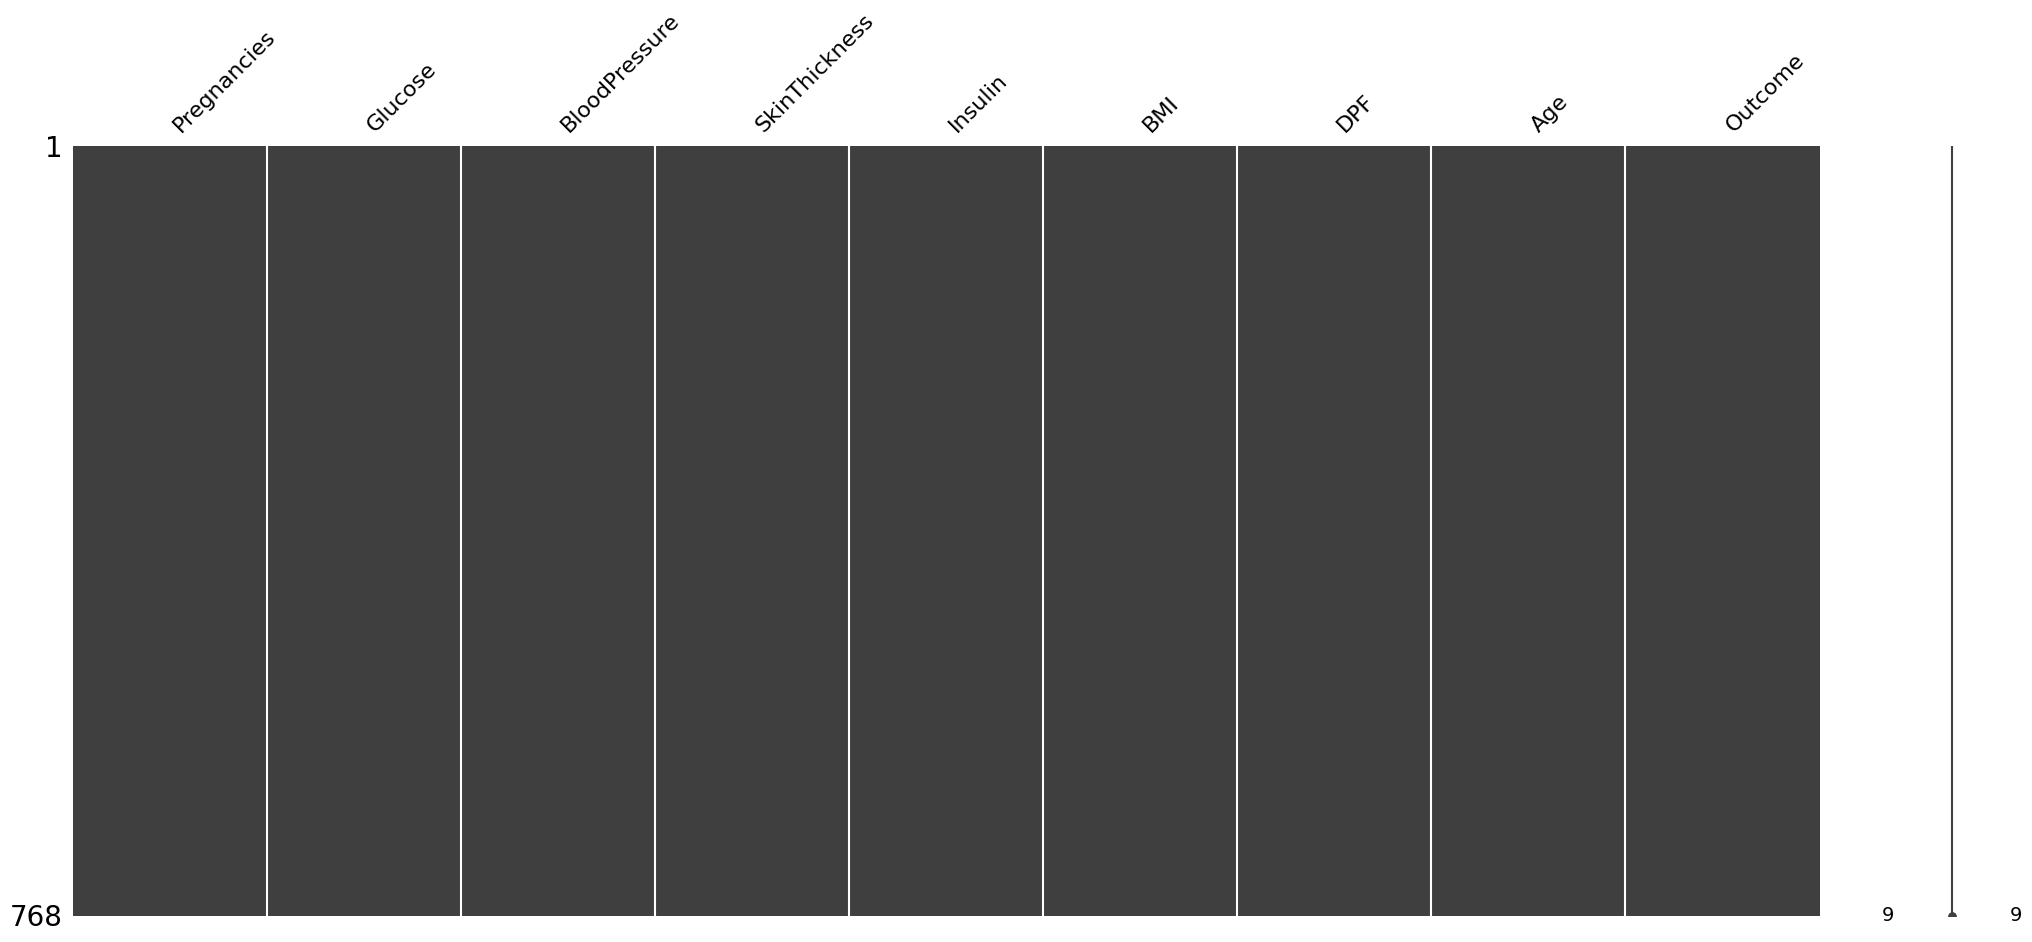

In [ ]:
import missingno as msno
msno.matrix(diabetes_df)

In [ ]:
colors = ['silver', 'black']
labels = ['0','1']
values = diabetes_df['Outcome'].value_counts()/diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Outcome")
fig.show()

In [ ]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
feature_names = [cname for cname in diabetes_df.loc[:,:'Age'].columns]

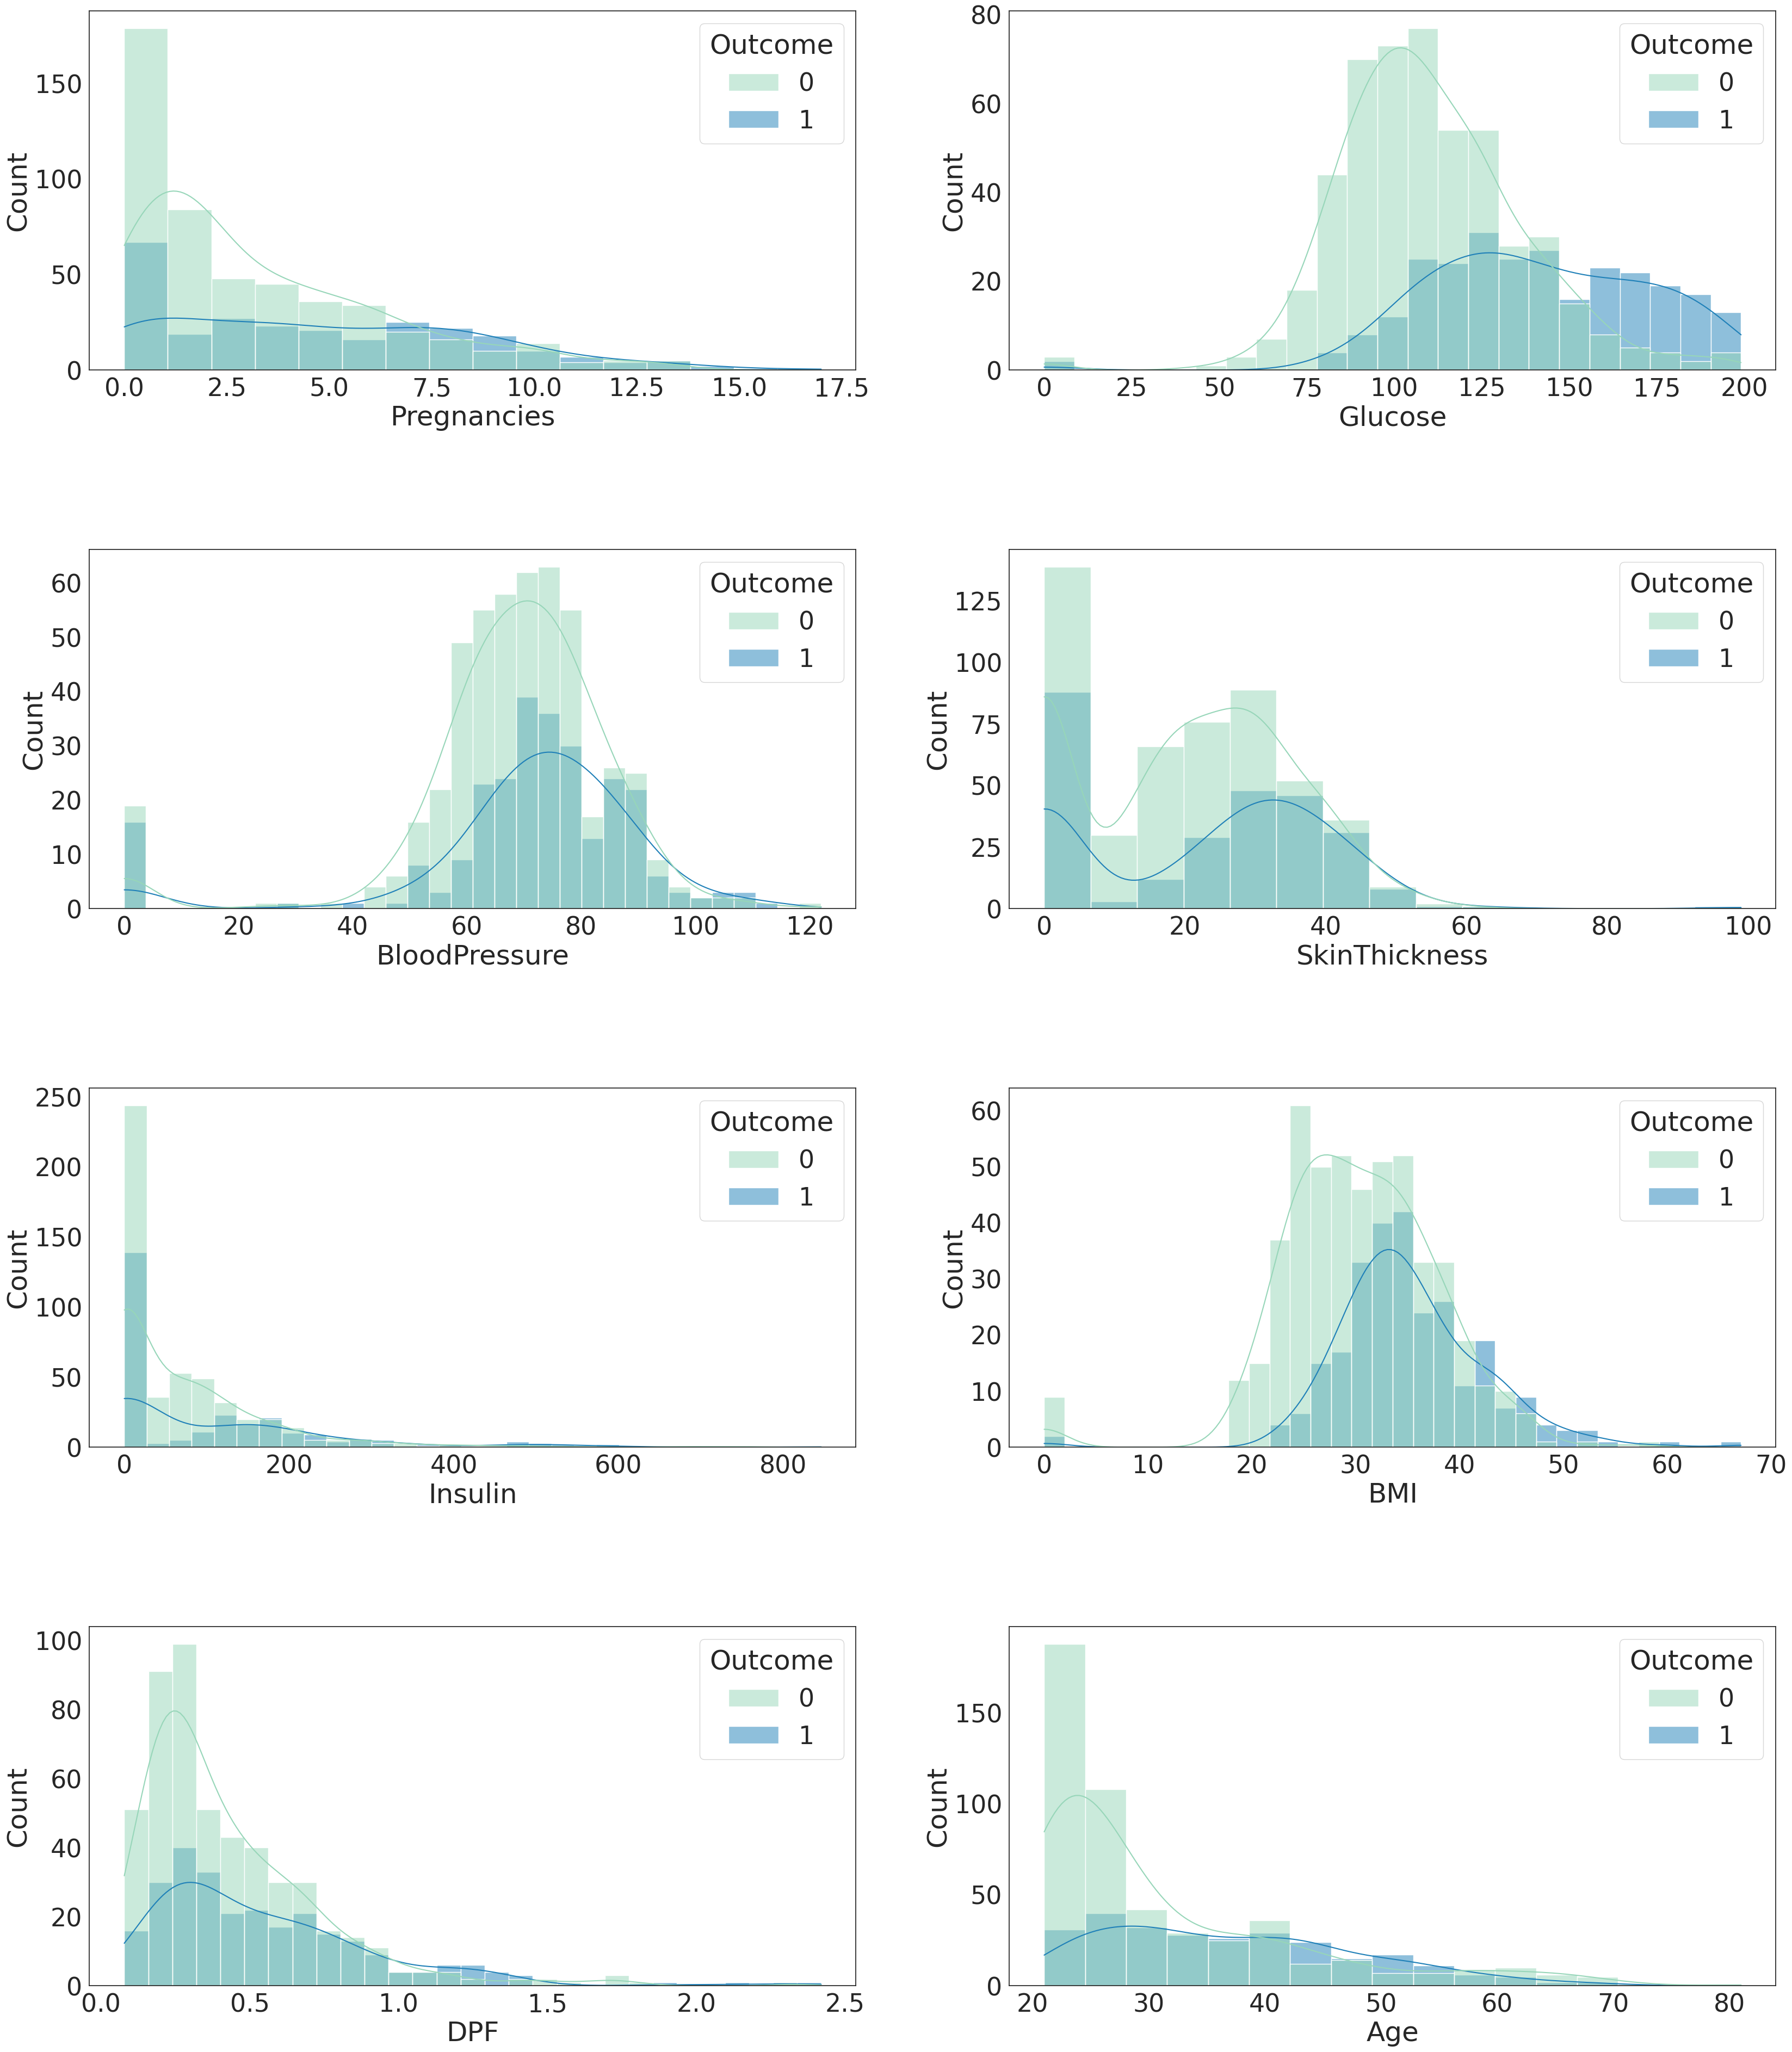

In [ ]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

In [ ]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature]==0][feature].count()
    print('{0} 0 number of cases {1}, percent is {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies 0 number of cases 111, percent is 14.45 %
Glucose 0 number of cases 5, percent is 0.65 %
BloodPressure 0 number of cases 35, percent is 4.56 %
SkinThickness 0 number of cases 227, percent is 29.56 %
Insulin 0 number of cases 374, percent is 48.70 %
BMI 0 number of cases 11, percent is 1.43 %


In [ ]:
diabetes_mean = diabetes_df[zero_features].mean()
diabetes_df[zero_features]=diabetes_df[zero_features].replace(0, diabetes_mean)

In [ ]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

In [ ]:
#scaling

In [ ]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,4.315407,121.709154,72.144653,26.341978,118.600098,32.315027,0.468618,32.921875
std,2.916151,30.080570,12.113756,9.158041,94.570101,6.878494,0.339325,11.507539
min,1.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,2.000000,100.000000,64.000000,20.536458,79.799479,27.275000,0.240000,24.000000
50%,3.845052,118.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000
75%,6.000000,138.250000,80.000000,32.000000,127.500000,36.325000,0.612250,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


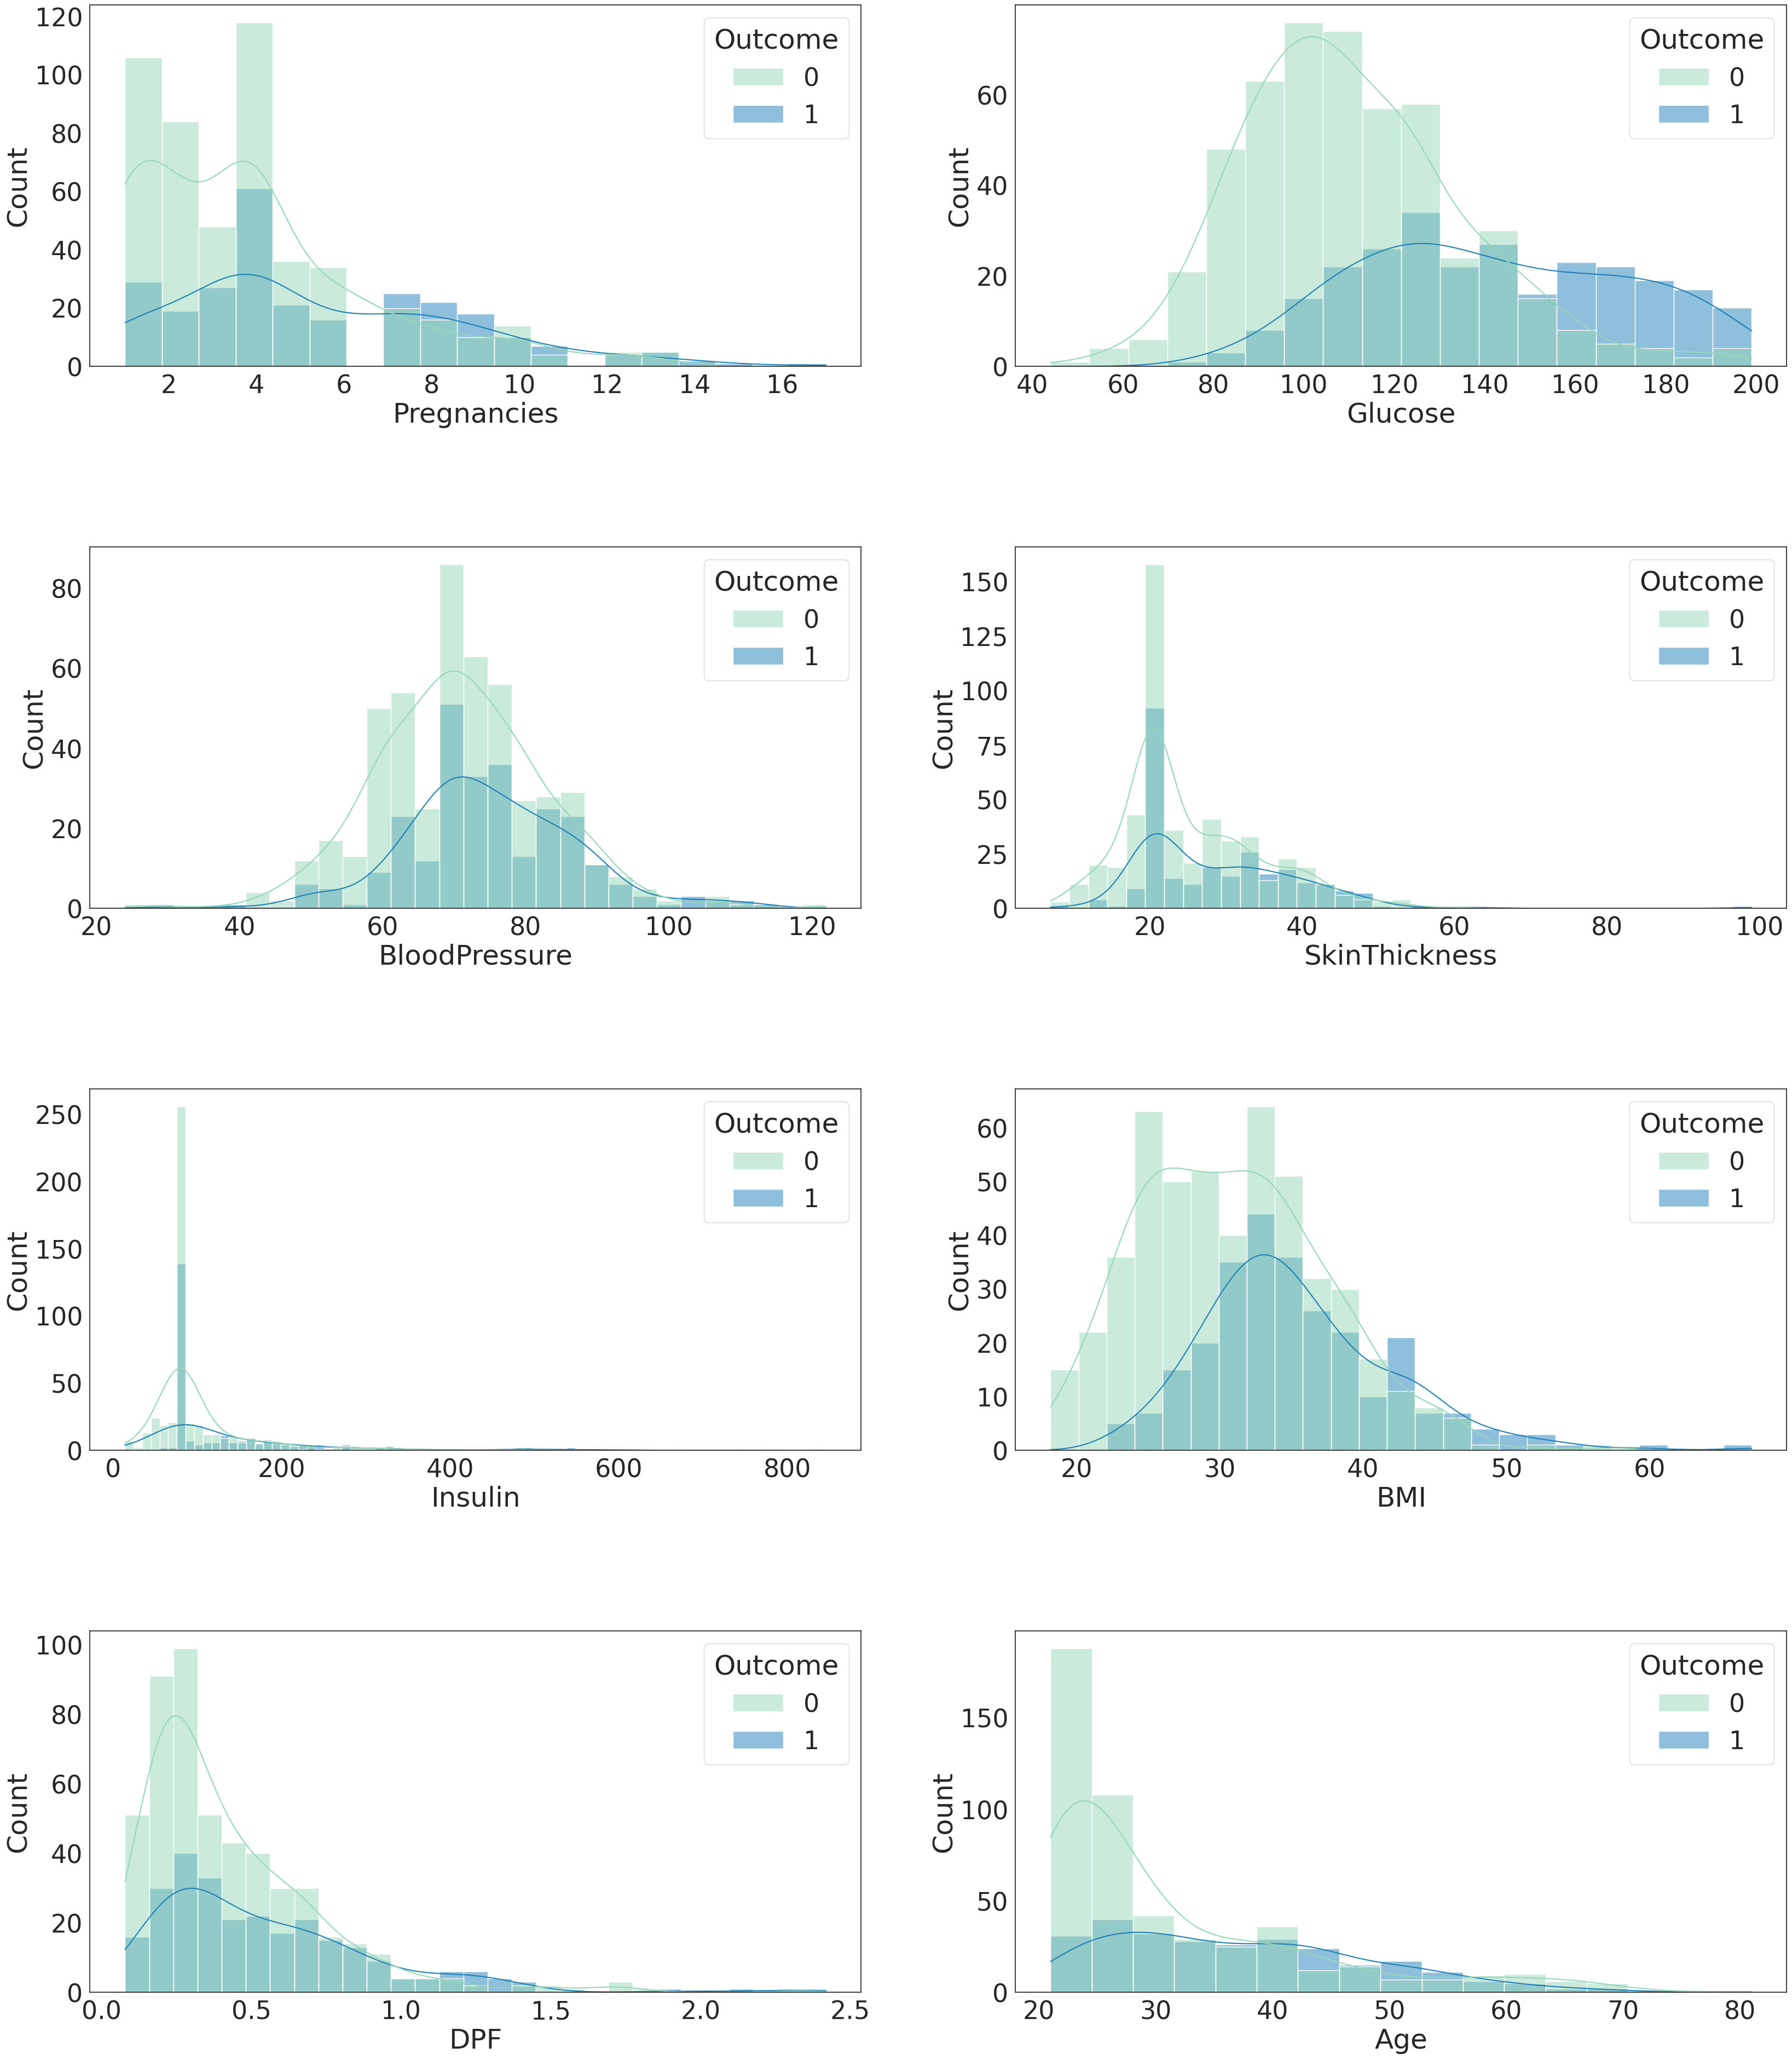

In [ ]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

Text(0.5, 1.0, 'Correlation Plot')

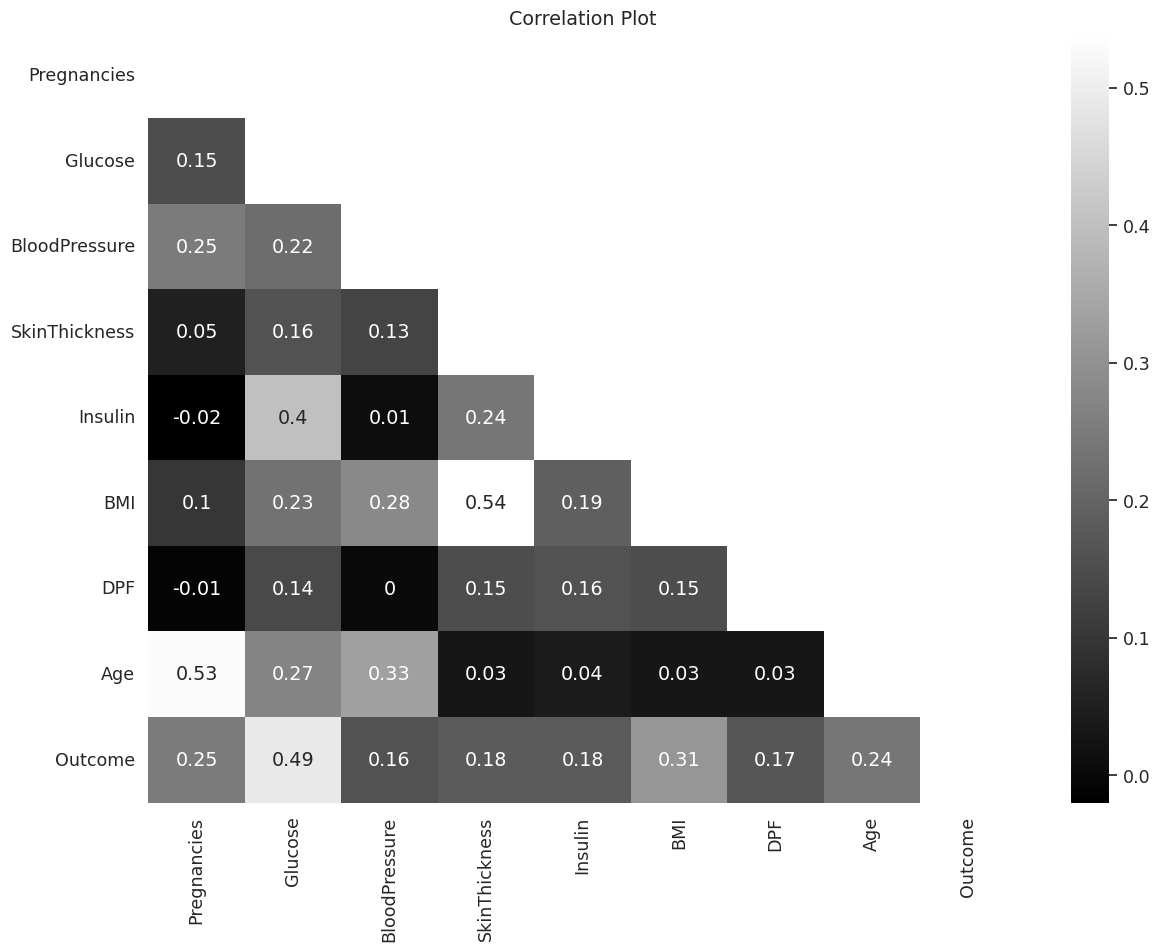

In [ ]:
#Checking correlation between features
corr=diabetes_df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

<Figure size 1000x800 with 0 Axes>

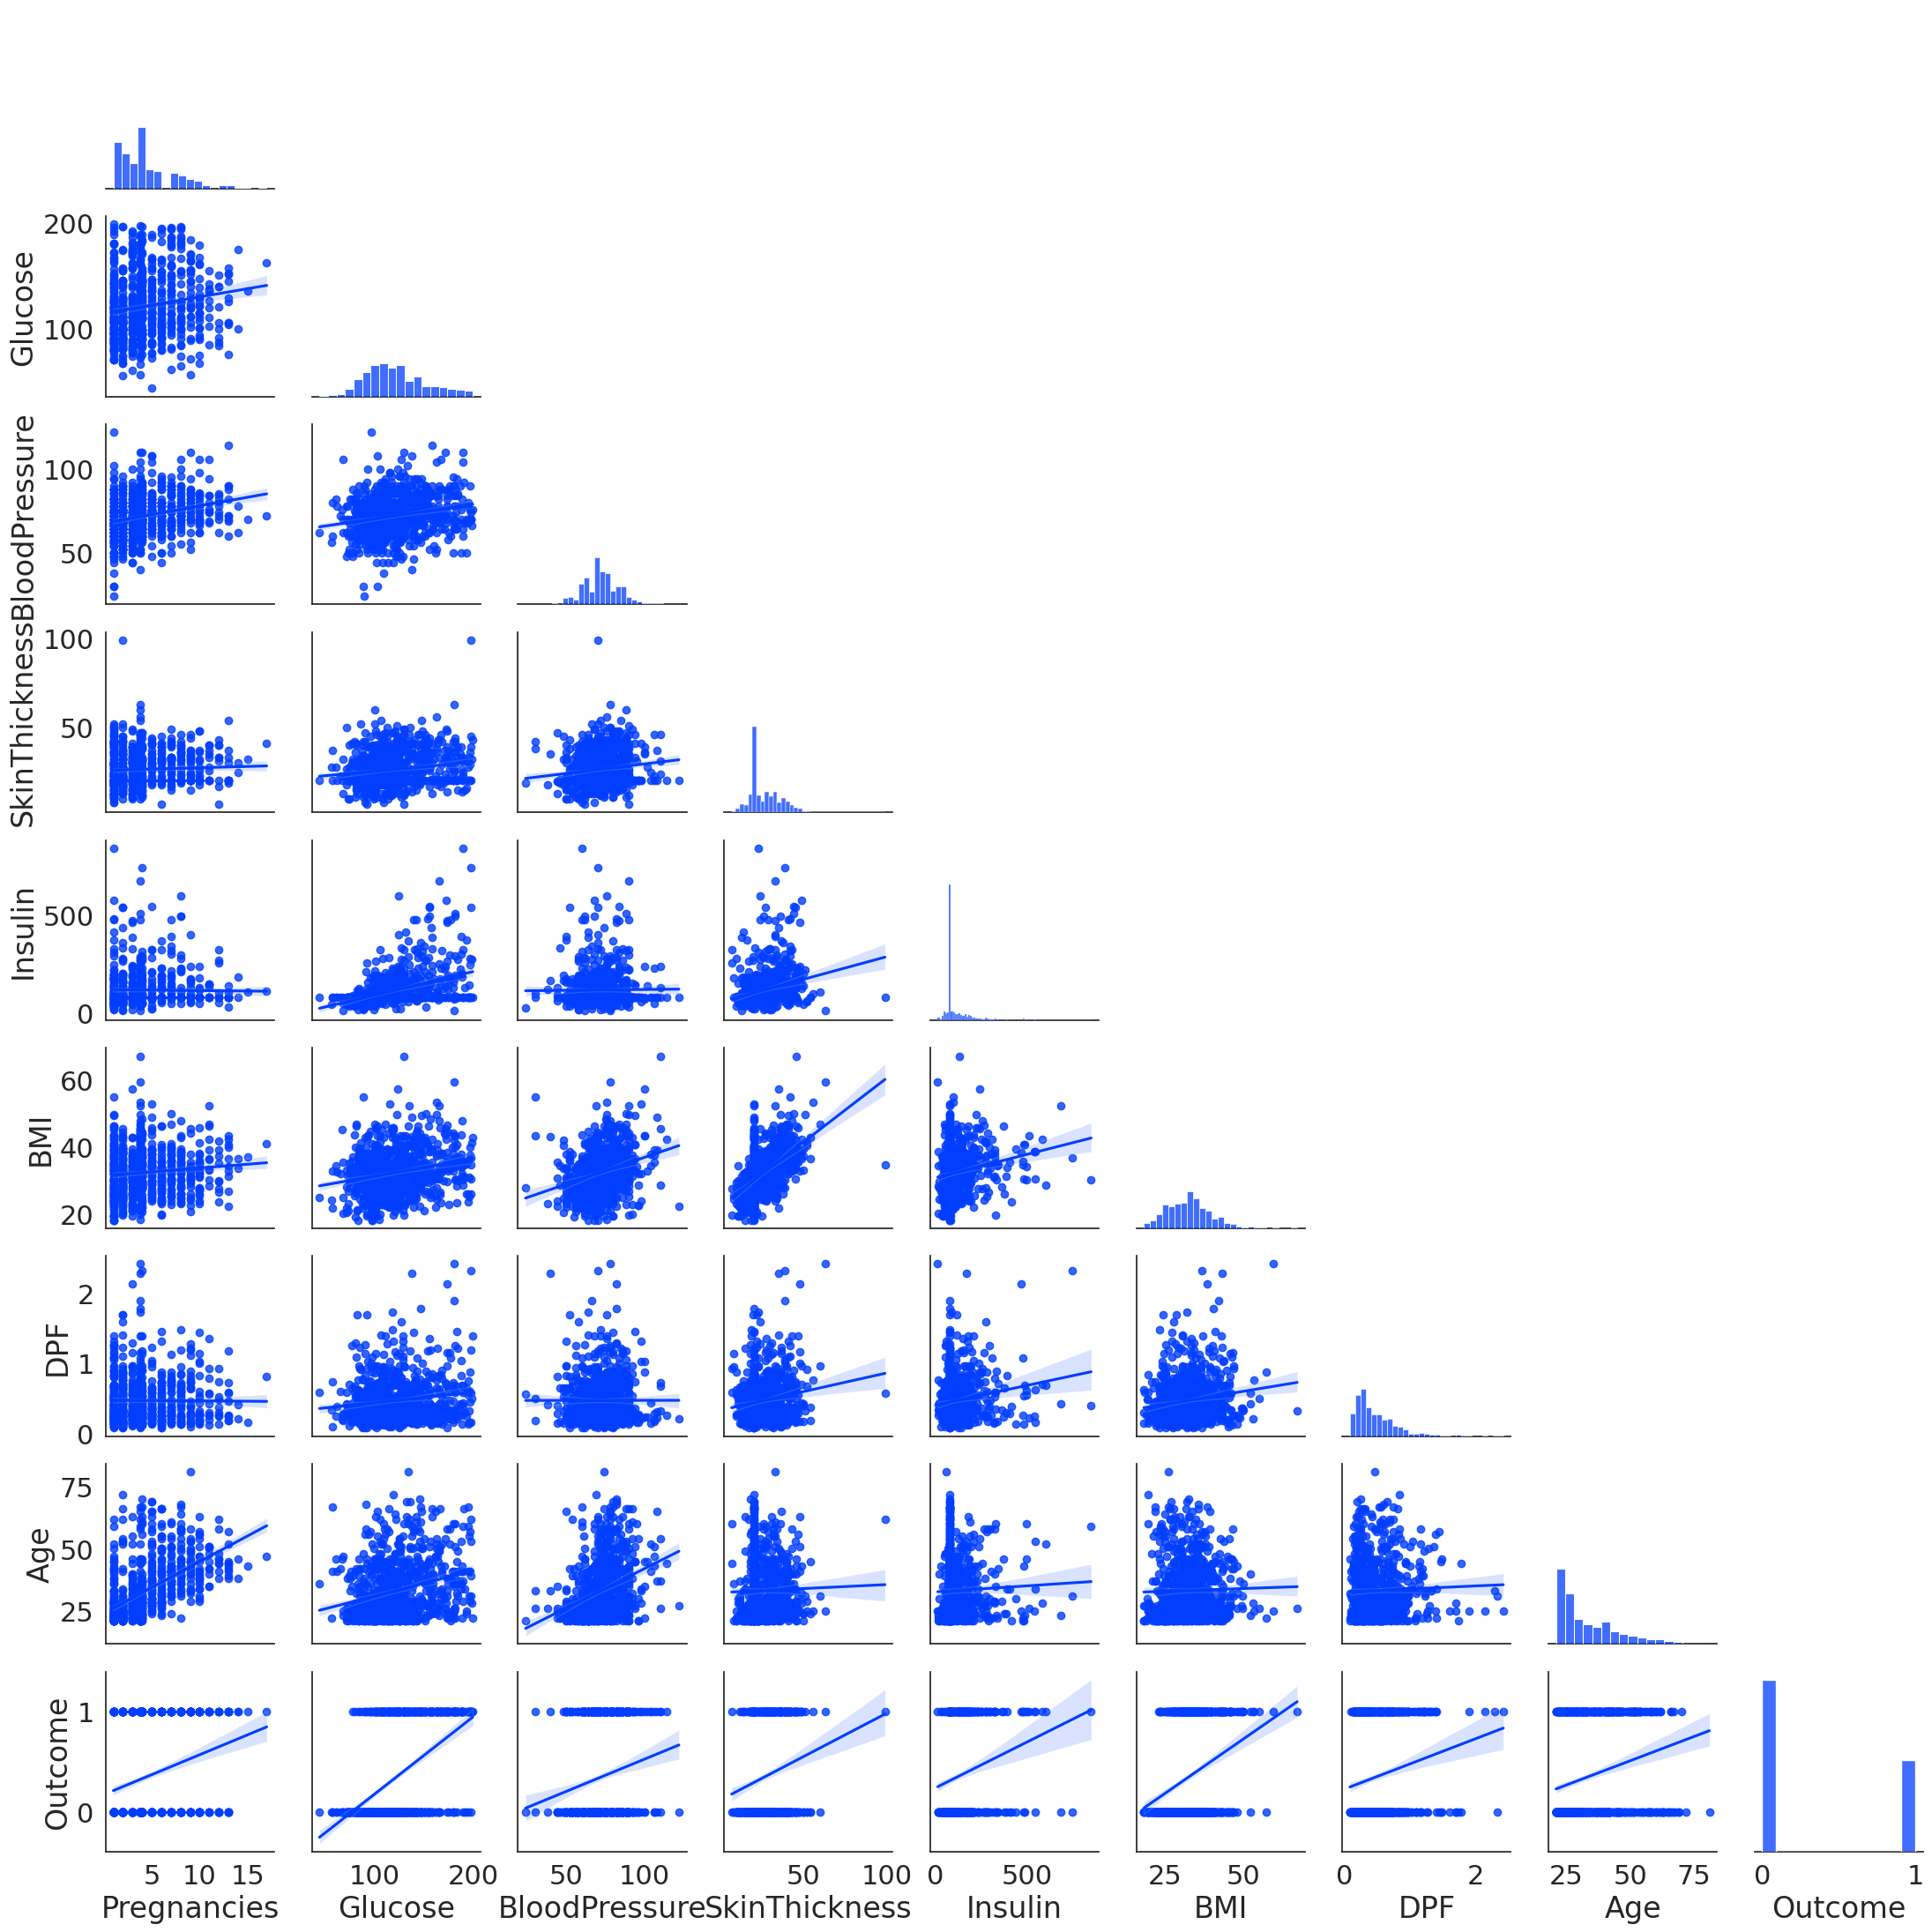

In [19]:
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(diabetes_df,kind = 'reg',corner = True,palette ='YlGnBu' )

In [ ]:
#Histogramsssssss

In [20]:
fig = px.histogram(diabetes_df, x="Glucose",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="Red",
    legend_title_font_color="Black",
    title={
        'text': "Glucose Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [21]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [22]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="Age",
                   color="Outcome",
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Age Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

In [ ]:
# making models and train them

In [32]:
!pip install bayesian-optimization


In [40]:
X_train = diabetes_df.drop('Outcome',axis=1)
y_train = diabetes_df['Outcome']

In [39]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define the function to optimize
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2):
    params = {
        'application': 'binary',
        'learning_rate': 0.05,
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'feature_fraction': max(min(feature_fraction, 1), 0),
        'bagging_fraction': max(min(bagging_fraction, 1), 0),
        'max_depth': int(max_depth),
        'lambda_l1': max(lambda_l1, 0),
        'lambda_l2': max(lambda_l2, 0)

    }

    cv_result = cross_val_score(
        lgb.LGBMClassifier(**params),
        X_train, y_train,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5),
        n_jobs=-1
    )

    return cv_result.mean()

# Define parameter bounds
lgbBO = BayesianOptimization(
    lgb_eval,
    {
        'num_leaves': (20, 150),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (5, 20),
        'lambda_l1': (0, 5),
        'lambda_l2': (0, 5)
    },
    random_state=0
)

# Perform optimization
lgbBO.maximize(init_points=8, n_iter=25)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | num_le... |
-------------------------------------------------------------------------------------------------
| 1         | 0.8342    | 0.9098    | 0.6722    | 3.014     | 2.724     | 11.35     | 104.0     |
| 2         | 0.8335    | 0.8875    | 0.8134    | 4.818     | 1.917     | 16.88     | 88.76     |
| 3         | 0.825     | 0.9136    | 0.8405    | 0.3552    | 0.4356    | 5.303     | 128.2     |
| 4         | 0.8337    | 0.9556    | 0.796     | 4.893     | 3.996     | 11.92     | 121.5     |
| 5         | 0.8315    | 0.8237    | 0.6119    | 0.7168    | 4.723     | 12.83     | 73.91     |
| 6         | 0.8316    | 0.8529    | 0.7194    | 2.281     | 2.842     | 5.282     | 100.3     |
| 7         | 0.8326    | 0.9224    | 0.5935    | 4.719     | 3.409     | 10.39     | 76.81     |
| 8         | 0.8319    | 0.9395    | 0.1482    | 3.334     | 3.353     | 8.156     | 36.76     |
| 9         | 0.8283

In [41]:
!pip install pandas matplotlib datashader bokeh holoviews scikit-image colorcet


<Axes: >

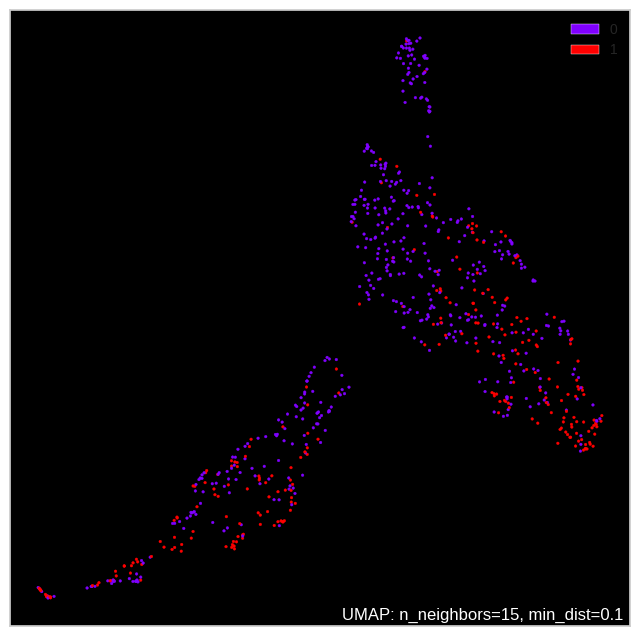

In [43]:
#2D Plot
import umap
import umap.plot

mapper = umap.UMAP().fit(X_train)
umap.plot.points(mapper, labels=y_train, theme='fire')

In [44]:
#3D Plot
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_train)
umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y_train,name='label').astype(str)
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='label', labels={'color': 'number'}
)
fig.update_traces(marker_size=1.5)
fig.show()

<class 'numpy.ndarray'>


In [45]:
from pycaret.classification import *

In [46]:
import pycaret
print(pycaret.__version__)


3.3.2


In [47]:
from pycaret.classification import *

# Initialize PyCaret
clf1 = setup(data=diabetes_df, target='Outcome',
             preprocess=False,
             verbose=False)




In [48]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=['xgboost','dummy','svm','ridge','knn','dt','nb','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7784,0.8505,0.5880,0.7329,0.6412,0.4862,0.5004,0.0200
lr,Logistic Regression,0.7803,0.8498,0.5933,0.7353,0.6455,0.4913,0.5054,0.6380
gbc,Gradient Boosting Classifier,0.7618,0.8436,0.6307,0.6722,0.6431,0.4661,0.4727,0.1570
et,Extra Trees Classifier,0.7652,0.8320,0.5982,0.6935,0.6344,0.4646,0.4733,0.1640
rf,Random Forest Classifier,0.7560,0.8251,0.5924,0.6665,0.6201,0.4431,0.4500,0.2780
ada,Ada Boost Classifier,0.7542,0.8096,0.6254,0.6546,0.6324,0.4499,0.4556,0.1060
lightgbm,Light Gradient Boosting Machine,0.7357,0.8075,0.5994,0.6352,0.6101,0.4118,0.4174,0.3120


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

In [49]:

rf = create_model('rf')
lr = create_model('lr')
lda = create_model('lda')
gbc = create_model('gbc')
lightgbm= create_model('lightgbm')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8541,0.5263,0.7692,0.6250,0.4749,0.4921
1,0.7407,0.8669,0.5789,0.6471,0.6111,0.4176,0.4190
2,0.8148,0.8857,0.7368,0.7368,0.7368,0.5940,0.5940
3,0.8704,0.8932,0.9474,0.7500,0.8372,0.7319,0.7457
4,0.7407,0.8323,0.5263,0.6667,0.5882,0.4028,0.4088
5,0.6481,0.7474,0.4211,0.5000,0.4571,0.1997,0.2013
6,0.7222,0.7511,0.6316,0.6000,0.6154,0.3982,0.3985
7,0.7547,0.7913,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7736,0.8214,0.6667,0.6667,0.6667,0.4952,0.4952


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8496,0.4211,0.7273,0.5333,0.3710,0.3976
1,0.7963,0.8752,0.5263,0.8333,0.6452,0.5123,0.5389
2,0.8148,0.8902,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.7778,0.8842,0.7368,0.6667,0.7000,0.5242,0.5259
4,0.8148,0.8406,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7222,0.8060,0.4737,0.6429,0.5455,0.3520,0.3605
6,0.7963,0.8105,0.8421,0.6667,0.7442,0.5787,0.5896
7,0.7170,0.8000,0.4444,0.6154,0.5161,0.3234,0.3320
8,0.8302,0.8730,0.7778,0.7368,0.7568,0.6265,0.6270


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8556,0.4211,0.7273,0.5333,0.3710,0.3976
1,0.7778,0.8767,0.4737,0.8182,0.6000,0.4609,0.4939
2,0.8148,0.8857,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.7963,0.8797,0.7368,0.7000,0.7179,0.5587,0.5591
4,0.8148,0.8421,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7037,0.8075,0.4737,0.6000,0.5294,0.3175,0.3223
6,0.7963,0.8165,0.8421,0.6667,0.7442,0.5787,0.5896
7,0.7170,0.7921,0.4444,0.6154,0.5161,0.3234,0.3320
8,0.8302,0.8746,0.7778,0.7368,0.7568,0.6265,0.6270


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8812,0.4737,0.6923,0.5625,0.3874,0.4014
1,0.7593,0.8586,0.7368,0.6364,0.6829,0.4906,0.4940
2,0.7963,0.8977,0.7368,0.7000,0.7179,0.5587,0.5591
3,0.7778,0.9113,0.8421,0.6400,0.7273,0.5456,0.5602
4,0.7778,0.8376,0.5789,0.7333,0.6471,0.4882,0.4954
5,0.6667,0.7820,0.4211,0.5333,0.4706,0.2322,0.2357
6,0.7407,0.7925,0.6842,0.6190,0.6500,0.4449,0.4463
7,0.7736,0.8063,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7925,0.8317,0.7222,0.6842,0.7027,0.5435,0.5439


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8331,0.4737,0.7500,0.5806,0.4236,0.4456
1,0.7407,0.8466,0.5789,0.6471,0.6111,0.4176,0.4190
2,0.7593,0.8812,0.6316,0.6667,0.6486,0.4658,0.4661
3,0.7778,0.8195,0.8421,0.6400,0.7273,0.5456,0.5602
4,0.7407,0.8105,0.4737,0.6923,0.5625,0.3874,0.4014
5,0.6111,0.7218,0.4737,0.4500,0.4615,0.1575,0.1576
6,0.6852,0.7383,0.6316,0.5455,0.5854,0.3338,0.3361
7,0.7547,0.7746,0.6111,0.6471,0.6286,0.4457,0.4461
8,0.7736,0.8413,0.6667,0.6667,0.6667,0.4952,0.4952


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 800x550 with 0 Axes>

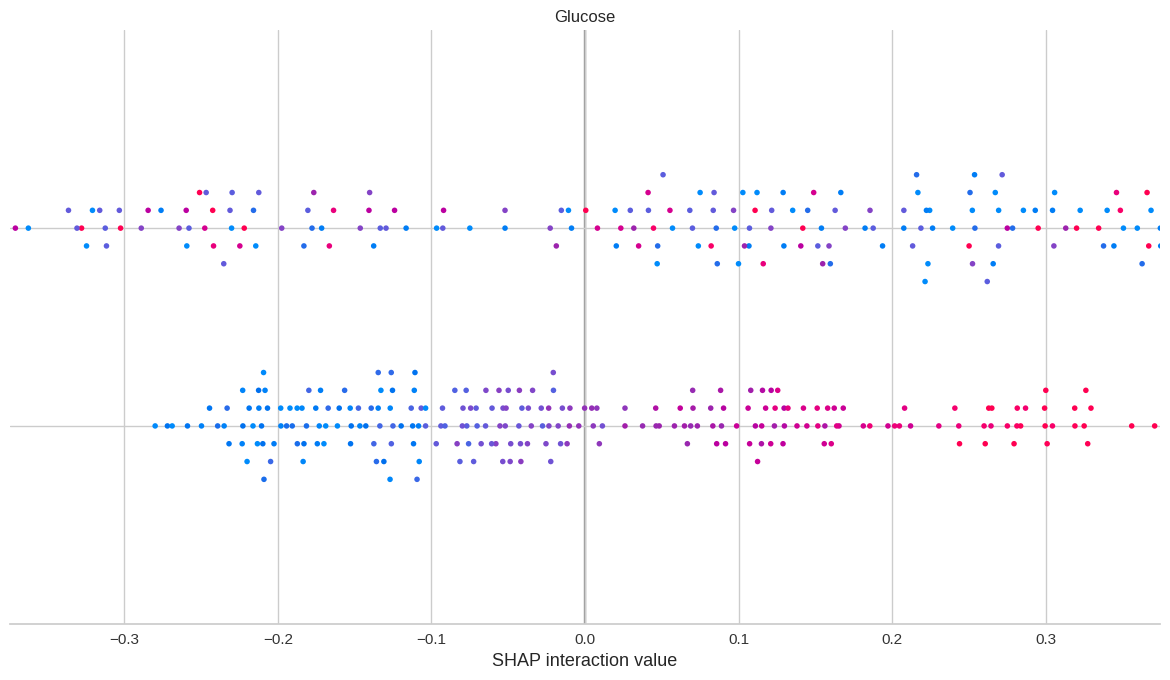

In [ ]:
interpret_model(rf)

In [ ]:
#Tuning Hyperparameters

In [50]:

tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')
tuned_lightgbm = tune_model(lightgbm, optimize='AUC')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.9188,0.4211,0.8000,0.5517,0.4081,0.4474
1,0.7593,0.8556,0.4737,0.7500,0.5806,0.4236,0.4456
2,0.8333,0.9188,0.6316,0.8571,0.7273,0.6112,0.6260
3,0.7778,0.8797,0.6842,0.6842,0.6842,0.5128,0.5128
4,0.7778,0.8135,0.4737,0.8182,0.6000,0.4609,0.4939
5,0.6852,0.8150,0.2632,0.6250,0.3704,0.2045,0.2385
6,0.7037,0.7759,0.5789,0.5789,0.5789,0.3504,0.3504
7,0.7358,0.8111,0.3889,0.7000,0.5000,0.3399,0.3670
8,0.7925,0.8587,0.6667,0.7059,0.6857,0.5310,0.5315


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,0.8586,0.7368,0.7778,0.7568,0.6301,0.6307
1,0.7778,0.8827,0.7368,0.6667,0.7000,0.5242,0.5259
2,0.7963,0.8782,0.7368,0.7000,0.7179,0.5587,0.5591
3,0.7593,0.8797,0.8947,0.6071,0.7234,0.5237,0.5548
4,0.7778,0.8436,0.6316,0.7059,0.6667,0.5008,0.5025
5,0.6852,0.8105,0.5789,0.5500,0.5641,0.3180,0.3182
6,0.7407,0.8120,0.8947,0.5862,0.7083,0.4926,0.5286
7,0.7547,0.8000,0.6111,0.6471,0.6286,0.4457,0.4461
8,0.8302,0.8825,0.8333,0.7143,0.7692,0.6362,0.6409


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8677,0.4737,0.7500,0.5806,0.4236,0.4456
1,0.7963,0.8812,0.5263,0.8333,0.6452,0.5123,0.5389
2,0.8148,0.8932,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.7963,0.8782,0.7895,0.6818,0.7317,0.5689,0.5729
4,0.8148,0.8361,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.7037,0.8060,0.4211,0.6154,0.5000,0.2998,0.3107
6,0.7593,0.8195,0.8421,0.6154,0.7111,0.5132,0.5318
7,0.7170,0.7921,0.4444,0.6154,0.5161,0.3234,0.3320
8,0.8302,0.8810,0.7778,0.7368,0.7568,0.6265,0.6270


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7222,0.8857,0.4211,0.6667,0.5161,0.3350,0.3524
1,0.7222,0.8556,0.5789,0.6111,0.5946,0.3836,0.3839
2,0.7963,0.8902,0.6316,0.7500,0.6857,0.5367,0.5410
3,0.7963,0.9233,0.8421,0.6667,0.7442,0.5787,0.5896
4,0.8148,0.8602,0.5263,0.9091,0.6667,0.5507,0.5902
5,0.6481,0.7835,0.4211,0.5000,0.4571,0.1997,0.2013
6,0.7407,0.7985,0.7368,0.6087,0.6667,0.4577,0.4633
7,0.7736,0.8175,0.5556,0.7143,0.6250,0.4664,0.4740
8,0.7736,0.8349,0.7222,0.6500,0.6842,0.5085,0.5102


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8962,0.3684,0.7778,0.5000,0.3538,0.3989
1,0.7778,0.8271,0.3684,1.0000,0.5385,0.4306,0.5238
2,0.8148,0.9023,0.5789,0.8462,0.6875,0.5624,0.5828
3,0.8148,0.8722,0.6316,0.8000,0.7059,0.5735,0.5820
4,0.7778,0.8090,0.4737,0.8182,0.6000,0.4609,0.4939
5,0.6667,0.8263,0.2105,0.5714,0.3077,0.1459,0.1774
6,0.7222,0.7970,0.5789,0.6111,0.5946,0.3836,0.3839
7,0.7358,0.8159,0.3889,0.7000,0.5000,0.3399,0.3670
8,0.7736,0.8603,0.6111,0.6875,0.6471,0.4812,0.4830


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#stacking

In [51]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8662,0.4211,0.8000,0.5517,0.4081,0.4474
1,0.7963,0.8827,0.5789,0.7857,0.6667,0.5248,0.5375
2,0.7963,0.8887,0.6316,0.7500,0.6857,0.5367,0.5410
3,0.7963,0.8812,0.7895,0.6818,0.7317,0.5689,0.5729
4,0.8148,0.8571,0.5789,0.8462,0.6875,0.5624,0.5828
5,0.6481,0.8015,0.3684,0.5000,0.4242,0.1792,0.1835
6,0.7407,0.8180,0.7895,0.6000,0.6818,0.4698,0.4825
7,0.7358,0.7746,0.5000,0.6429,0.5625,0.3775,0.3836
8,0.8302,0.8508,0.7778,0.7368,0.7568,0.6265,0.6270


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

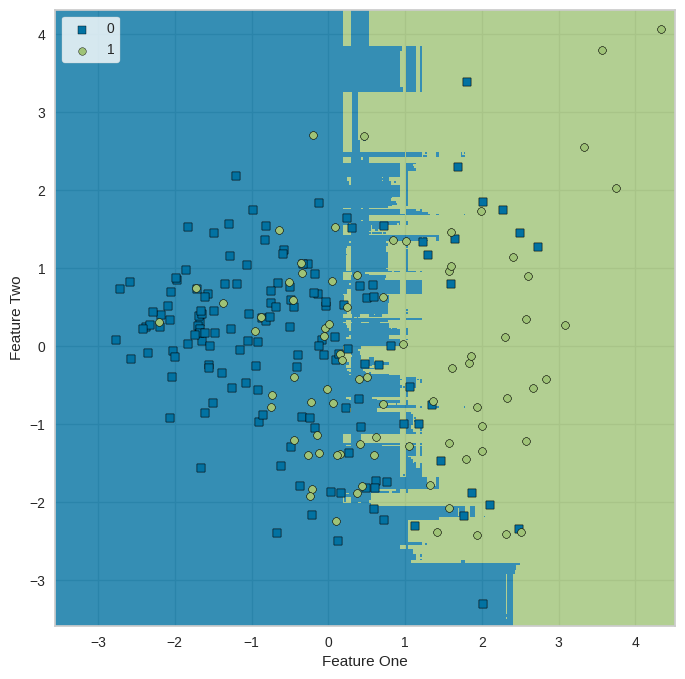

In [52]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

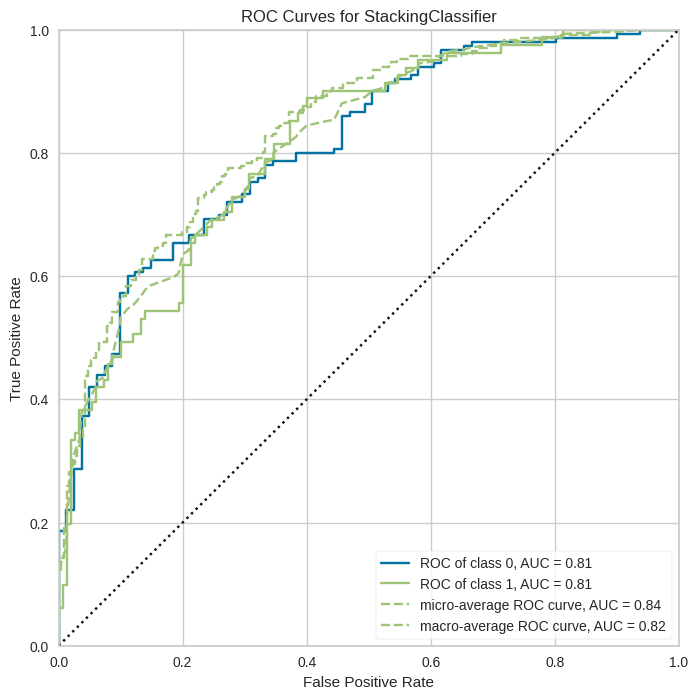

In [53]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

In [54]:
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9010, precision: 0.8676, recall: 0.8551,    F1: 0.8613, AUC:0.9449


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

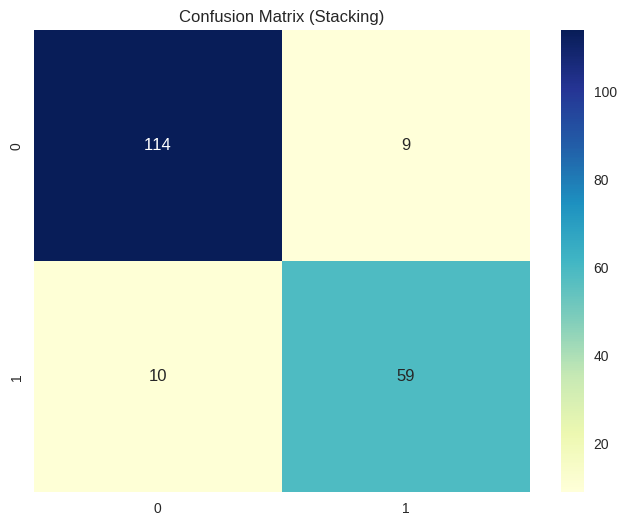

In [55]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [ ]:
#soft and hard voting

In [56]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7593,0.8752,0.4737,0.7500,0.5806,0.4236,0.4456
1,0.8148,0.8797,0.6316,0.8000,0.7059,0.5735,0.5820
2,0.8148,0.8932,0.6316,0.8000,0.7059,0.5735,0.5820
3,0.8148,0.9008,0.7895,0.7143,0.7500,0.6035,0.6054
4,0.7963,0.8692,0.5263,0.8333,0.6452,0.5123,0.5389
5,0.6296,0.7985,0.3158,0.4615,0.3750,0.1248,0.1293
6,0.7407,0.8150,0.7368,0.6087,0.6667,0.4577,0.4633
7,0.7547,0.7984,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7925,0.8603,0.6667,0.7059,0.6857,0.5310,0.5315


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

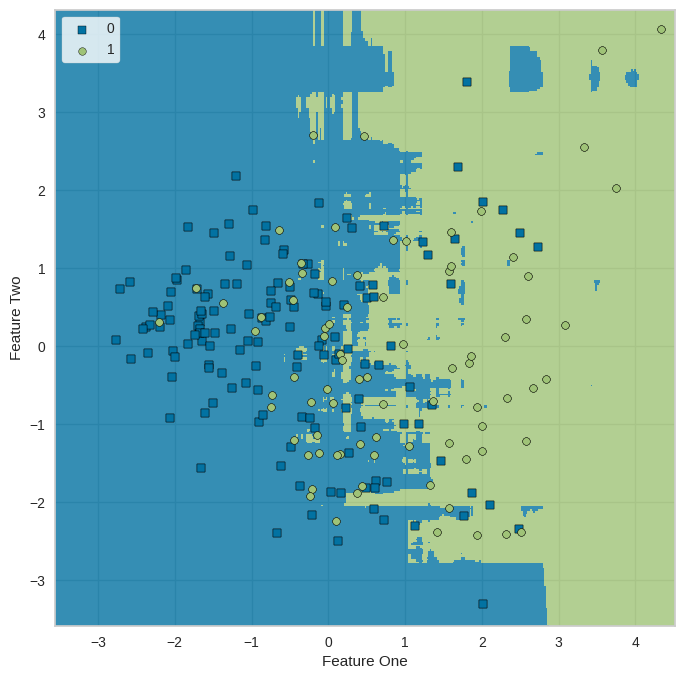

In [57]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

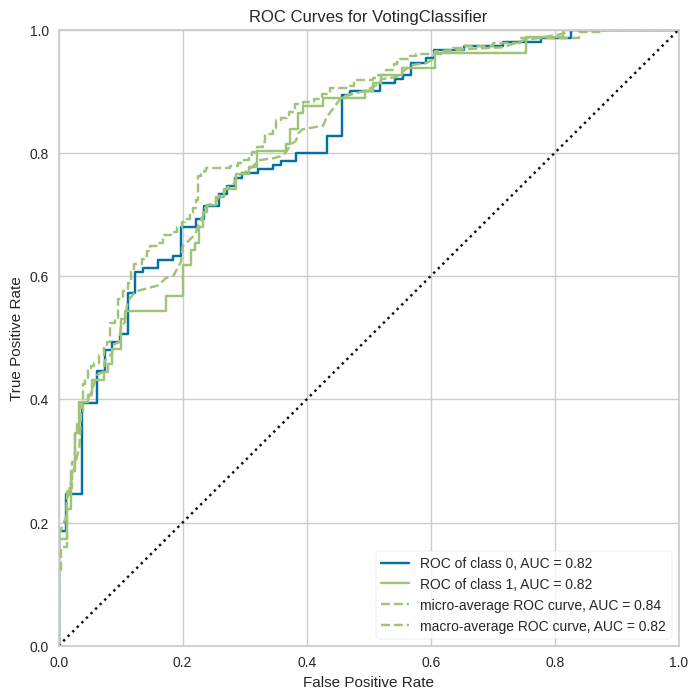

In [58]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [59]:

pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9323, precision: 0.9242, recall: 0.8841,    F1: 0.9037, AUC:0.9513


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

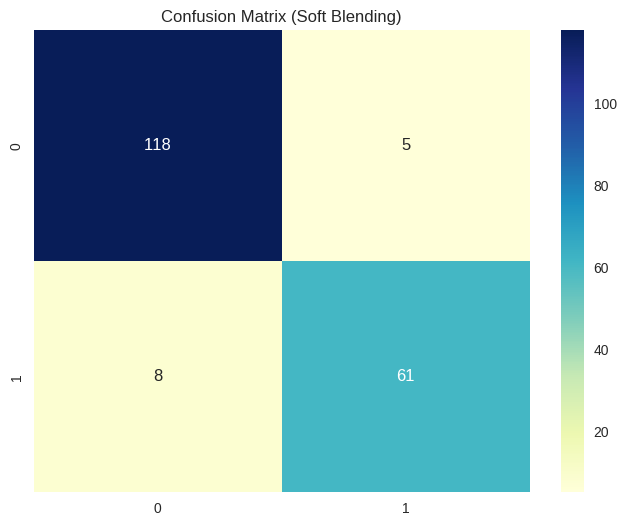

In [60]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

In [61]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.0000,0.4211,0.7273,0.5333,0.3710,0.3976
1,0.7963,0.0000,0.5789,0.7857,0.6667,0.5248,0.5375
2,0.8333,0.0000,0.6842,0.8125,0.7429,0.6209,0.6259
3,0.8333,0.0000,0.8421,0.7273,0.7805,0.6473,0.6518
4,0.7963,0.0000,0.5263,0.8333,0.6452,0.5123,0.5389
5,0.6296,0.0000,0.3158,0.4615,0.3750,0.1248,0.1293
6,0.7407,0.0000,0.7368,0.6087,0.6667,0.4577,0.4633
7,0.7547,0.0000,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7925,0.0000,0.6667,0.7059,0.6857,0.5310,0.5315


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

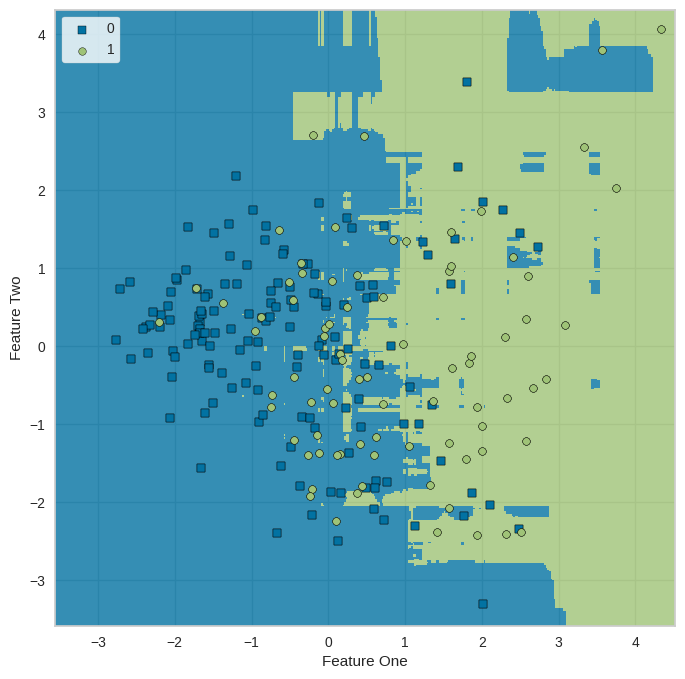

In [62]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

In [64]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9219, precision: 0.9219, recall: 0.8551,F1: 0.8872


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

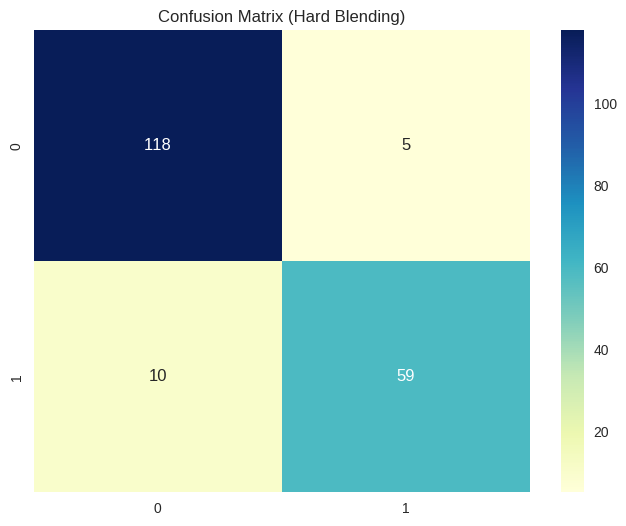

In [65]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

In [66]:
#calibarating the final model

cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8887,0.4737,0.8182,0.6000,0.4609,0.4939
1,0.7778,0.8842,0.5789,0.7333,0.6471,0.4882,0.4954
2,0.8333,0.9008,0.6316,0.8571,0.7273,0.6112,0.6260
3,0.8333,0.8947,0.8421,0.7273,0.7805,0.6473,0.6518
4,0.7963,0.8617,0.5263,0.8333,0.6452,0.5123,0.5389
5,0.6481,0.8045,0.3684,0.5000,0.4242,0.1792,0.1835
6,0.7407,0.8180,0.7368,0.6087,0.6667,0.4577,0.4633
7,0.7547,0.8048,0.5000,0.6923,0.5806,0.4136,0.4246
8,0.7925,0.8746,0.7222,0.6842,0.7027,0.5435,0.5439


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#Finalizing the last model

In [67]:
final_model = finalize_model(cali_model)

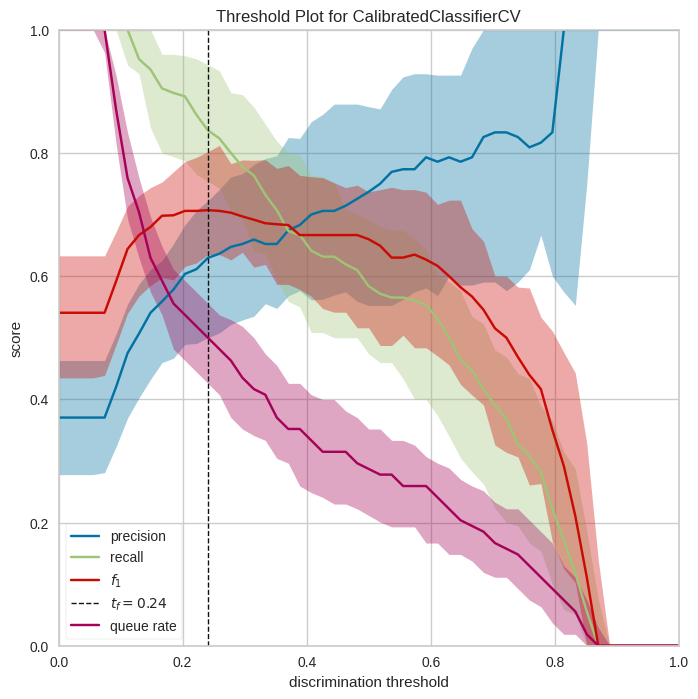

In [69]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

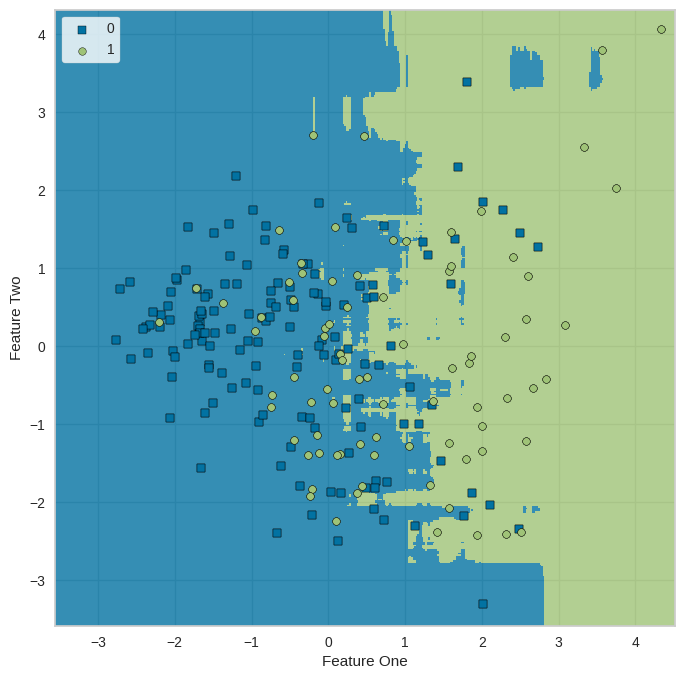

In [70]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [71]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9323, precision: 0.9242, recall: 0.8841,F1: 0.9037


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

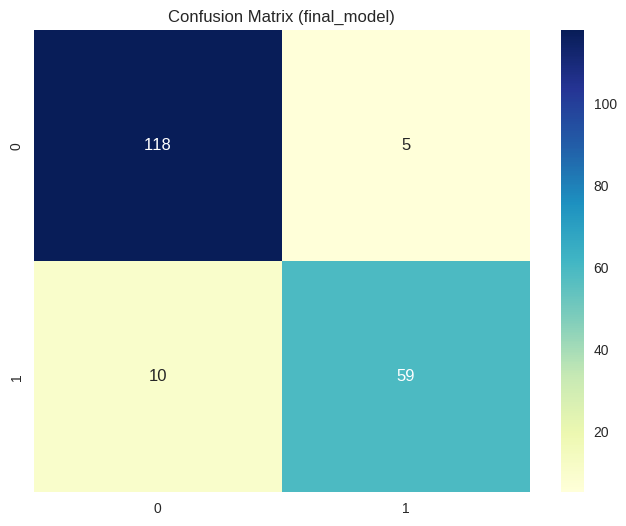

In [72]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')